# **Machine Learning para Negocios - Predicción de Churn**

* Este notebook está diseñado para personas sin experiencia previa en ML. 
* Objetivo: Predecir si un cliente hará un churn (abandono) usando distintos modelos de ML.
* Visualizar Underfitting vs Overfitting con métricas y gráficas.

# **¿Qué es un Churn?**

Churn ocurre cuando un cliente deja de usar un producto o servicio.

Ejemplos:

* Cancela subscripción
* Deja de comprar
* Se va con  la competencia

Esto es un problema clásico de clasificación binaria:

* 0 → No churn
* 1 → Churn

# **Dataset de Negocio (Simulado)**

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification # función que genera datasets sintéticos
from sklearn.model_selection import train_test_split # función divide los datos en conjuntos de entrenamiento y prueba
from sklearn.metrics import accuracy_score # función que calcula la exactitud del modelo, de esta manera podemos saber si esta sobreajustado o subajustado

In [24]:
X, y = make_classification(
    n_samples=2000, # número de muestras
    n_features=6,  # número de características
    n_informative=4,  # número de características informativas
    n_redundant=1,  # número de características redundantes
    n_classes=2, # número de clases
    weights=[0.7, 0.3], # distribución de clases desbalanceada 
    random_state=42 # reproduce el mismo dataset cada vez que se ejecuta el código
)

columns = [
    'tenure_months', # duración del contrato en meses
    'monthly_charges', # cargos mensuales
    'usage_level', # nivel de uso del servicio
    'support_tickets', # número de tickets de soporte
    'discount_flag', # indicador de descuento aplicado
    'contract_type' # tipo de contrato, # los modelos de ML no pueden trabajar con variables string.
]

df = pd.DataFrame(X, columns=columns)
df['churn'] = y

df.head()

,tenure_months,monthly_charges,usage_level,support_tickets,discount_flag,contract_type,churn
0,-1.101699,-0.734518,0.108393,-0.189459,-0.559962,0.847294,0
1,1.237495,-0.523637,-0.235316,-1.132829,-0.945952,0.573169,0
2,-0.829820,-0.182240,0.520623,0.174152,-0.034772,0.346180,0
3,-1.352138,-0.721564,-0.279812,-0.895505,-1.110221,1.257867,0
4,-1.092563,-0.730788,-0.636699,-1.333284,-1.342253,0.196545,0


In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    df[columns], # características
    df['churn'], # variable objetivo
    test_size=0.3, # 30% de los datos para prueba
    random_state=42 # reproduce la misma división cada vez que se ejecuta el código
)

In [26]:
# Función de evaluación
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train) # entrenar el modelo
    train_acc = accuracy_score(y_train, model.predict(X_train)) # exactitud en el conjunto de entrenamiento
    test_acc = accuracy_score(y_test, model.predict(X_test)) # exactitud en el conjunto de prueba
    return train_acc, test_acc

# **Decission Tree**

In [27]:
from sklearn.tree import DecisionTreeClassifier

dt_simple = DecisionTreeClassifier(max_depth=2, random_state=42) # modelo simple
dt_complex = DecisionTreeClassifier(max_depth=10, random_state=42) # modelo complejo

dt_simple_scores = evaluate_model(dt_simple, X_train, X_test, y_train, y_test)
dt_complex_scores = evaluate_model(dt_complex, X_train, X_test, y_train, y_test)

dt_simple_scores, dt_complex_scores

((0.8028571428571428, 0.8266666666666667),
 (0.9521428571428572, 0.8733333333333333))

1) **Tree simple** (`max_depth=2`)

    * Train: 0.8029
    * Test: 0.8267

        🔎 Interpretación:

        Están muy parecidos (incluso el test un poquito más alto, cosa que puede pasar por azar en la partición). Lo que sugiere buena generalización y poco sobreajuste.

        Podría haber un poquito de subajuste, porque con tan poca profundidad el árbol no puede capturar relaciones más complejas, pero no es grave: es un baseline sano.

2) **Tree complejo** (`max_depth=10`)

    * Train: 0.9521

    * Test: 0.8733

        🔎 Interpretación:
       
        * 0.9521 − 0.8733 = 0.0788 (≈ 7.9 puntos)

        Eso es señal típica de sobreajuste: el modelo aprende muy bien el train, pero no mejora proporcionalmente en test.

# **Logistic Regression**

* Solo puede producir variables discretas

In [28]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr_scores = evaluate_model(lr, X_train, X_test, y_train, y_test)

lr_scores

(0.7614285714285715, 0.7783333333333333)

3) **Logistic Regression**

    * Train: 0.7614

    * Test: 0.7783

    🔎 Interpretación:

    Train y test están muy cercanos → casi nada de sobreajuste. Pero el rendimiento es más bajo que tus Decision Trees:

    * Árbol depth=2: test 0.8267
    * Árbol depth=10: test 0.8733
    * LogReg: test 0.7783

    Aquí la Logistic Regression se ve como subajustada (underfitting) comparada con el árbol, porque es un modelo lineal: solo puede trazar una frontera “recta” (en un espacio 6D), mientras que el árbol puede capturar relaciones no lineales e interacciones.

# **KNN**

In [29]:
from sklearn.neighbors import KNeighborsClassifier

knn_small = KNeighborsClassifier(n_neighbors=1) # modelo con bajo sesgo y alta varianza
knn_large = KNeighborsClassifier(n_neighbors=15) # modelo con alto sesgo y baja varianza

knn_small_scores = evaluate_model(knn_small, X_train, X_test, y_train, y_test) # evaluar el modelo
knn_large_scores = evaluate_model(knn_large, X_train, X_test, y_train, y_test) 

knn_small_scores, knn_large_scores

((1.0, 0.8833333333333333), (0.9071428571428571, 0.9066666666666666))

4) **KNN con k=1 (n_neighbors=1)**

    * Train: 1.00

    * Test: 0.8833
    
    🔎 Interpretación:

    Esto es el ejemplo clásico de sobreajuste (alta varianza):

    * Con k=1, cada punto “se memoriza” → en entrenamiento siempre acierta (por eso 1.0). En test baja porque es muy sensible al ruido (cualquier vecino raro te cambia la clase).

    Analogía: es como “aprenderse las respuestas exactas del examen pasado”, pero no entender el tema.

5) **KNN con k=15**

    * Train: 0.9071

    * Test: 0.9067

    🔎 Interpretación:

    Aquí hay un modelo más estable:

    * Train y test casi iguales → generaliza muy bien (baja varianza). Y además… el test es mejor que el k=1
    (0.9067 > 0.8833)

    Analogía: ahora en vez de preguntarle a 1 amigo qué hacer, le preguntas a 15 y haces “voto mayoritario” → menos extremos.

# **Ramdom Forest**

* Acumalación de árbol de decisión

In [30]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, max_depth=6, random_state=42) # modelo de bosque aleatorio
rf_scores = evaluate_model(rf, X_train, X_test, y_train, y_test) # evaluar el modelo

rf_scores

(0.8821428571428571, 0.8816666666666667)

6) Random Forest

    * Train: 0.8821

    * Test: 0.8817

    🔎 Interpretación:

    * Train ≈ Test (diferencia ≈ 0.0005) → casi nada de sobreajuste.
    * Eso es justo lo que suele dar Random Forest: reduce varianza frente a un árbol único (promedia muchos árboles).

    Analogía: un árbol es “una opinión”; un Random Forest es un “comité” de árboles votando. Menos caprichoso, más estable.

---

# **Visualización: Train vs Test (Overfitting)**

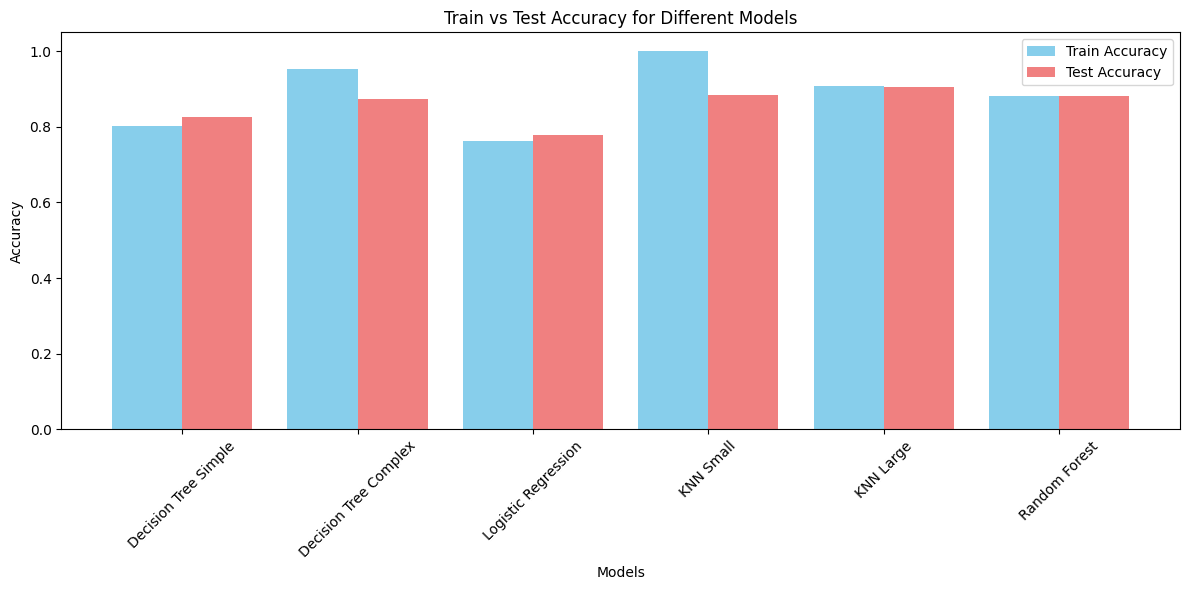

In [31]:
models = [
    'Decision Tree Simple',
    'Decision Tree Complex',
    'Logistic Regression',
    'KNN Small',
    'KNN Large',
    'Random Forest'
]

train_scores = [
    dt_simple_scores[0],
    dt_complex_scores[0],
    lr_scores[0],
    knn_small_scores[0],
    knn_large_scores[0],
    rf_scores[0]
]

test_scores = [
    dt_simple_scores[1],
    dt_complex_scores[1],
    lr_scores[1],
    knn_small_scores[1],
    knn_large_scores[1],
    rf_scores[1]
]

x = np.arange(len(models)) # la ubicación de las etiquetas
plt.figure(figsize=(12, 6))
plt.bar(x-0.2, train_scores, width=0.4, label='Train Accuracy', color='skyblue')
plt.bar(x+0.2, test_scores, width=0.4, label='Test Accuracy', color='lightcoral')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy for Different Models')
plt.xticks(x, models, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# **Conclusiones de Negocio**

* Cuando Train >> Test → Overfitting
* Cuando ambos son bajos → Underfitting
* Modelos como Random Forest suelen generalizar mejor
* Logistic Regression es una excelente baseline para negocio

# **Conclusiones Finales**

En este notebook construimos un primer flujo completo de Machine Learning para un problema clásico de negocio: predecir churn (abandono) como una clasificación binaria (0 = no churn, 1 = churn). La meta no fue solo “entrenar modelos”, sino entender cómo se comportan y cómo justificar una elección de modelo con base en evidencia.

A lo largo del ejercicio comparamos distintos algoritmos (Decision Tree, Logistic Regression, KNN y Random Forest) y visualizamos la diferencia entre underfitting y overfitting usando métricas de entrenamiento vs prueba. Vimos casos típicos como:

* Modelos que generalizan bien cuando train y test son similares.
* Modelos que sobreajustan cuando el desempeño en train es muy alto pero cae en test.
* Modelos que pueden subajustar cuando son demasiado simples para capturar patrones no lineales.

Para un enfoque de enseñanza, el modelo más valioso no siempre es el de mayor exactitud, sino el que podemos explicar y defender fácilmente. Por eso, un árbol de decisión simple es una excelente opción didáctica: permite entender la lógica del modelo como reglas “SI → ENTONCES”, y facilita comunicar resultados a negocio. Aun así, también observamos que modelos como KNN (k grande) o Random Forest pueden lograr gran estabilidad y buen rendimiento, aunque requieren más trabajo para explicarlos (por ejemplo, con importancias de variables o técnicas de interpretación).

Finalmente, este notebook refuerza un punto clave: EDA (Exploratory Data Analysis) sigue siendo esencial. Antes de entrenar cualquier modelo, es necesario explorar y validar los datos (distribuciones, desbalance de clases, valores atípicos, calidad de variables y posibles fugas de información). Machine Learning no “predice el futuro” como magia: estima probabilidades basadas en patrones históricos, y su utilidad depende de la calidad de los datos, la evaluación correcta y el contexto del negocio.

📌 **En resumen:** este proyecto muestra cómo pasar de datos a un modelo básico, cómo detectar overfitting/underfitting y cómo pensar como científico de datos al momento de elegir un modelo que sea útil, entendible y defendible.